In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

## Download Reaching dataset

#### reaching_dataset.h5 [[download link](https://northwestern.app.box.com/s/xbe3xpnv6gpx0c1mrfhb1bal4cyei5n8)] [137MB]

## Load data

In [2]:
import deepdish as dd
reach_data = dd.io.load('reaching_dataset.h5')

print 'dataset keys:', reach_data.keys()
print 'events:', reach_data['events'].keys()
print 'features', reach_data['features'].keys()
print 'number of PMd neurons:', len(reach_data['neurons_PMd'])
print 'number of M1 neurons:', len(reach_data['neurons_M1'])

dataset keys: ['neurons_M1', 'neurons_PMd', 'events', 'features']
events: ['rewardTime', 'goCueTime', 'targetOnTime']
features ['endpointOfReach', 'reward']
number of PMd neurons: 195
number of M1 neurons: 219


# Part I: NeuroVis

In [3]:
from spykes.neurovis import NeuroVis

### Instantiate example PMd neuron

In [4]:
neuron_number = 91
spike_times = reach_data['neurons_PMd'][neuron_number-1]
neuron_PMd = NeuroVis(spike_times, name = 'PMd %d' % neuron_number)

## Raster plot and PSTH aligned to target onset

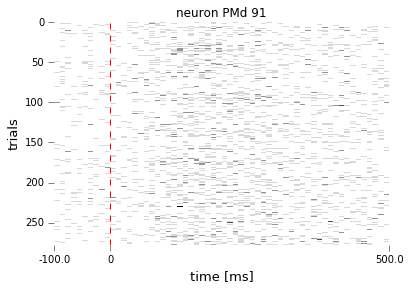

In [5]:
neuron_PMd.get_raster(event='targetOnTime', df=reach_data['events']);

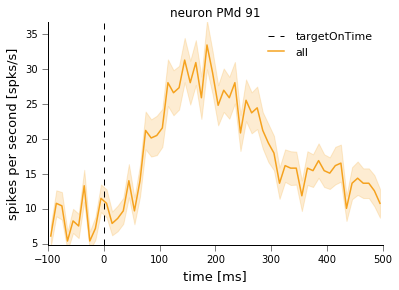

In [6]:
neuron_PMd.get_psth(event='targetOnTime', df=reach_data['events']);

## Let's put the data into a DataFrame

## Events

In [7]:
data_df = pd.DataFrame()
events = ['targetOnTime', 'goCueTime','rewardTime']

for i in events:
    data_df[i] = np.squeeze(reach_data['events'][i])


data_df[events].head()

,targetOnTime,goCueTime,rewardTime
0,4.355233,5.241967,5.566
1,43.675367,44.611100,44.757
2,49.542800,50.428800,50.609
3,61.530700,62.383467,62.711
4,69.219667,70.122100,70.562


## Features

In [8]:
data_df['endpointOfReach'] = np.squeeze(reach_data['features']['endpointOfReach'])    
data_df['reward_code'] = reach_data['features']['reward']

features = ['endpointOfReach','reward_code']    
data_df[features].head()

,endpointOfReach,reward_code
0,353.215892,34
1,137.280635,32
2,356.903709,32
3,53.357484,32
4,139.366650,32


## Let's visualize PSTHs separated by conditions

### Example 1: Reward vs No Reward

In [9]:
# We could use 'reward_code' but let's create a boolean feature for reward
data_df['reward'] = data_df['reward_code'].map(lambda s: {32:True, 34:False, '':np.nan}[s])
data_df.head()

,targetOnTime,goCueTime,rewardTime,endpointOfReach,reward_code,reward
0,4.355233,5.241967,5.566,353.215892,34,False
1,43.675367,44.611100,44.757,137.280635,32,True
2,49.542800,50.428800,50.609,356.903709,32,True
3,61.530700,62.383467,62.711,53.357484,32,True
4,69.219667,70.122100,70.562,139.366650,32,True


#### Plot PSTH

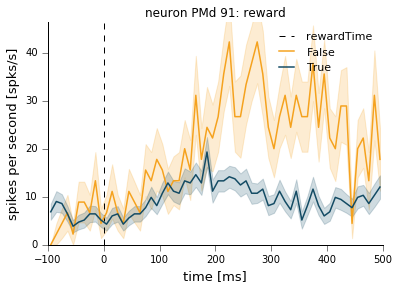

In [10]:
psth = neuron_PMd.get_psth(event='rewardTime',
                           conditions='reward', 
                           df=data_df);

#### Make it look nicer

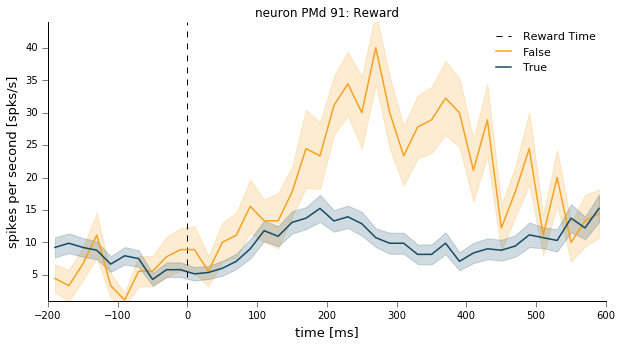

In [11]:
plt.figure(figsize=(10,5))
psth = neuron_PMd.get_psth(event='rewardTime',
                           conditions='reward', 
                           df=data_df,
                           window=[-200,600],
                           binsize=20,
                           event_name='Reward Time');

plt.title('neuron %s: Reward' % neuron_PMd.name)
plt.show()

### Example 2: according to quadrant of reaching direction
We can use the `pandas` method `cut()` for this:

In [12]:
data_df['endpointOfReach_quad'] = pd.cut(data_df['endpointOfReach'], np.linspace(0, 360, 5))
data_df[['endpointOfReach', 'endpointOfReach_quad']].head()

,endpointOfReach,endpointOfReach_quad
0,353.215892,"(270, 360]"
1,137.280635,"(90, 180]"
2,356.903709,"(270, 360]"
3,53.357484,"(0, 90]"
4,139.366650,"(90, 180]"


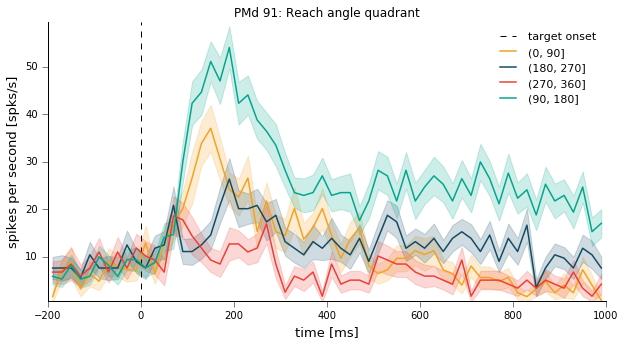

In [13]:
plt.figure(figsize=(10,5))
psth_PMd = neuron_PMd.get_psth(event='targetOnTime',
                               conditions='endpointOfReach_quad',
                               df=data_df,
                               window=[-200,1000],
                               binsize=20,
                               event_name='target onset');

plt.title('%s: Reach angle quadrant' % neuron_PMd.name)
plt.show()

#### Raster plots for the same neuron and conditions

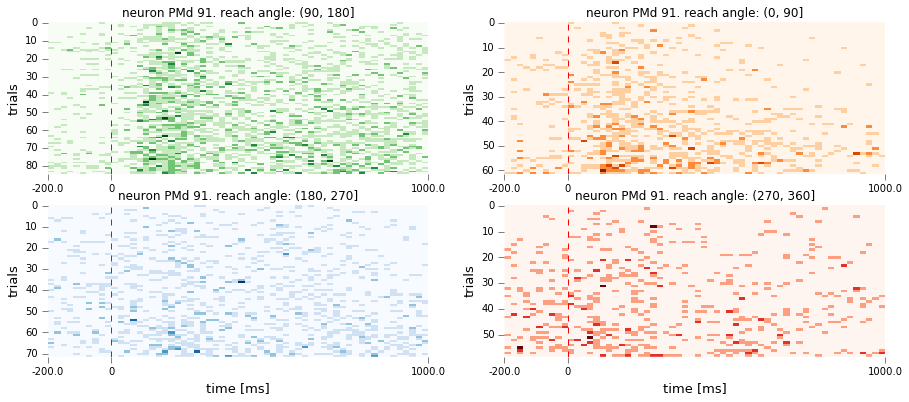

In [14]:
#get rasters
rasters_PMd = neuron_PMd.get_raster(event='targetOnTime',
                                    conditions='endpointOfReach_quad', 
                                    df=data_df,
                                    window=[-200,1000],
                                    binsize=20, 
                                    plot=False)


#plot rasters
plt.figure(figsize=(15,6))
plot_order = np.array([2,3,4,1])
cmap = ['Oranges','Blues','Reds','Greens']
for i, cond_id in enumerate(np.sort(rasters_PMd['data'].keys())):
    plt.subplot(2,2,plot_order[i])
    neuron_PMd.plot_raster(rasters_PMd, 
                           cond_id = cond_id,
                           cmap = cmap[i],
                           cond_name= 'reach angle: %s' % cond_id,
                           sortby='rate', sortorder='ascend')
    if plot_order[i]<3:
        plt.xlabel('')

### Example 3: Same as Example 2 but for an M1 neuron and aligned at goCueTime

In [15]:
neuron_number = 100
spike_times = reach_data['neurons_M1'][neuron_number-1]
neuron_M1 = NeuroVis(spike_times, name = 'M1 %d' % neuron_number)

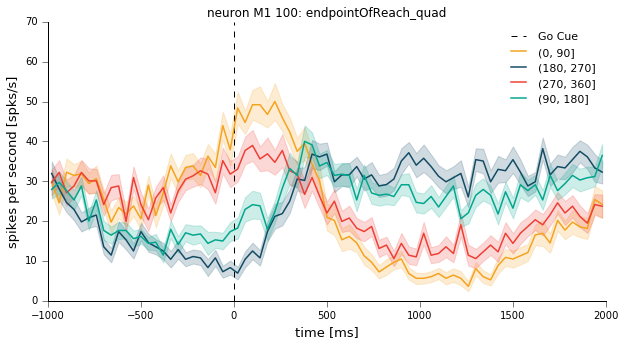

In [16]:
plt.figure(figsize=(10,5))
psth_M1 = neuron_M1.get_psth(event='goCueTime',
                             df=data_df,
                             conditions='endpointOfReach_quad',
                             window=[-1000,2000],
                             binsize=40,
                             plot=True,
                             ylim=[0,70],
                             event_name='Go Cue');
plt.show()

### Example 4: sorted by direction only for the trials with reward

In [17]:
#use standard pandas filtering to isolate trials of interest
trials_df = data_df[data_df['reward']==True]
trials_df.head()

,targetOnTime,goCueTime,rewardTime,endpointOfReach,reward_code,reward,endpointOfReach_quad
1,43.675367,44.611100,44.757,137.280635,32,True,"(90, 180]"
2,49.542800,50.428800,50.609,356.903709,32,True,"(270, 360]"
3,61.530700,62.383467,62.711,53.357484,32,True,"(0, 90]"
4,69.219667,70.122100,70.562,139.366650,32,True,"(90, 180]"
5,73.950900,74.803100,75.213,356.589493,32,True,"(270, 360]"


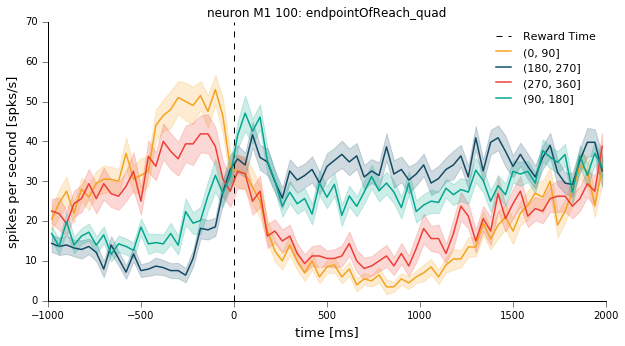

In [18]:
plt.figure(figsize=(10,5))
psth_M1 = neuron_M1.get_psth(event='rewardTime',
                             conditions='endpointOfReach_quad',
                             df=trials_df,
                             window=[-1000,2000],
                             binsize=40,
                             ylim=[0,70],
                             event_name='Reward Time'
                             );
plt.show()

## One last thing before moving on to `spykes.neuropop`

#### We can use `get_spikecounts()` to count the number of spikes within a certain time window relative to event onset 

In [19]:
spike_counts = neuron_PMd.get_spikecounts('targetOnTime', df=data_df, window=[0, 1200])

In [20]:
conditions_names = np.unique(data_df['endpointOfReach_quad'])
conditions_names = conditions_names[[0, 3, 1, 2]]
conditions_names

array(['(0, 90]', '(90, 180]', '(180, 270]', '(270, 360]'], dtype=object)

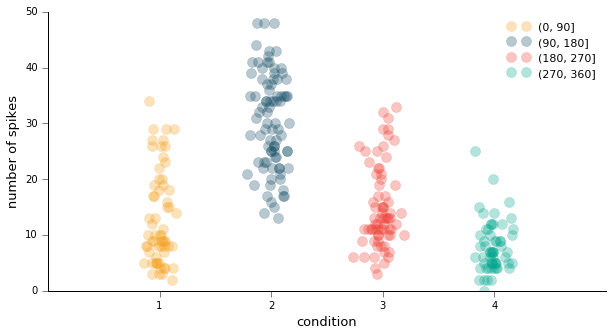

In [21]:
# Let's visualize the spike counts per trial for each condition
colors=['#F5A21E', '#134B64', '#EF3E34', '#02A68E']

plt.figure(figsize=(10,5))
for i, cond in enumerate(conditions_names):
    idx = np.where(data_df['endpointOfReach_quad']==cond)[0]
    x_noise = 0.08*np.random.randn(np.size(idx))
    plt.plot(i+x_noise+1, spike_counts[idx],'.', color=colors[i], alpha=0.3, markersize=20)
    
plt.xlabel('condition')
plt.ylabel('number of spikes')
plt.xlim([0,5])
plt.xticks(np.arange(np.size(conditions_names))+1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')
plt.legend(conditions_names, frameon=False)
plt.show()

# Part II: NeuroPop

In [22]:
from spykes.neuropop import NeuroPop

## Organize data as preferred features and spike counts ($x$,  $\mathbf{Y}$)

### Extract reach direction $x$

In [23]:
# Get reach direction, ensure it is between [-pi, pi]
x = np.arctan2(np.sin(reach_data['features']['endpointOfReach']*np.pi/180.0),
               np.cos(reach_data['features']['endpointOfReach']*np.pi/180.0))

### Extract M1 spike counts $\mathbf{Y}$ 
- Select only neurons above a threshold firing rate 
- Align spike counts to the GO cue
- Use the convenience function ```get_spikecounts()``` from ```NeuroVis```

In [24]:
# Select only high firing rate neurons
M1_select = list()
threshold = 10.0

# Specify timestamps of events to which trials are aligned
align = 'goCueTime'

# Specify a window of around the go cue for spike counts
window = [0., 500.] # milliseconds

# Get spike counts
Y = np.zeros([x.shape[0], len(reach_data['neurons_M1'])])

for n in range(len(reach_data['neurons_M1'])):
    this_neuron = NeuroVis(spiketimes = reach_data['neurons_M1'][n])
    Y[:, n] = np.squeeze(this_neuron.get_spikecounts(event=align, df=data_df, window=window))

    # Short list a few high-firing neurons
    if this_neuron.firingrate > threshold:
        M1_select.append(n)

# Rescale spike counts to units of spikes/s
Y = Y/float(window[1]-window[0])*1e3

# How many neurons shortlisted?
print '%d M1 neurons had firing rates over %4.1f spks/s' % (len(M1_select), threshold)

107 M1 neurons had firing rates over 10.0 spks/s


### Split into train and test sets

In [25]:
from sklearn.cross_validation import train_test_split
Y_train, Y_test, x_train, x_test = train_test_split(Y, x, test_size=0.33, random_state=42)

### Create an instance of NeuroPop

In [26]:
pop = NeuroPop(n_neurons=len(M1_select), 
               tunemodel='gvm',
               n_repeats = 3,
               verbose=False)

## Let's fit tuning curves to the population

In [27]:
pop.fit(np.squeeze(x_train), Y_train[:, M1_select])

### Predict firing rates

In [28]:
Yhat_test = pop.predict(np.squeeze(x_test))

### Score the prediction

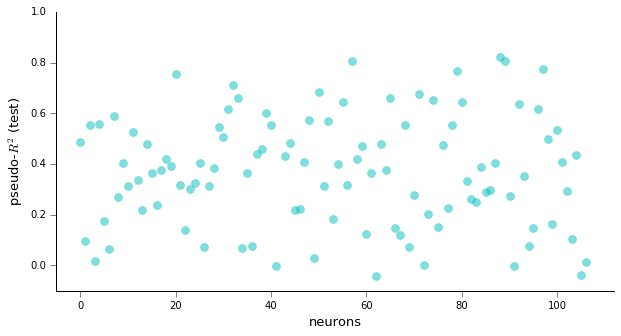

In [29]:
# calculate and plot the pseudo R2
Ynull = np.mean(Y_train[:, M1_select], axis=0)
pseudo_R2 = pop.score(Y_test[:, M1_select], Yhat_test, Ynull, method='pseudo_R2')

plt.figure(figsize=(10,5))
plt.plot(pseudo_R2, 'co', markeredgecolor='c', alpha=0.5, markersize=8)
plt.xlim([-5, len(M1_select)+5])
plt.ylim([-0.1, 1])
plt.xlabel('neurons')
plt.ylabel('pseudo-$R^2$ (test)')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')

### Visualize tuning curves

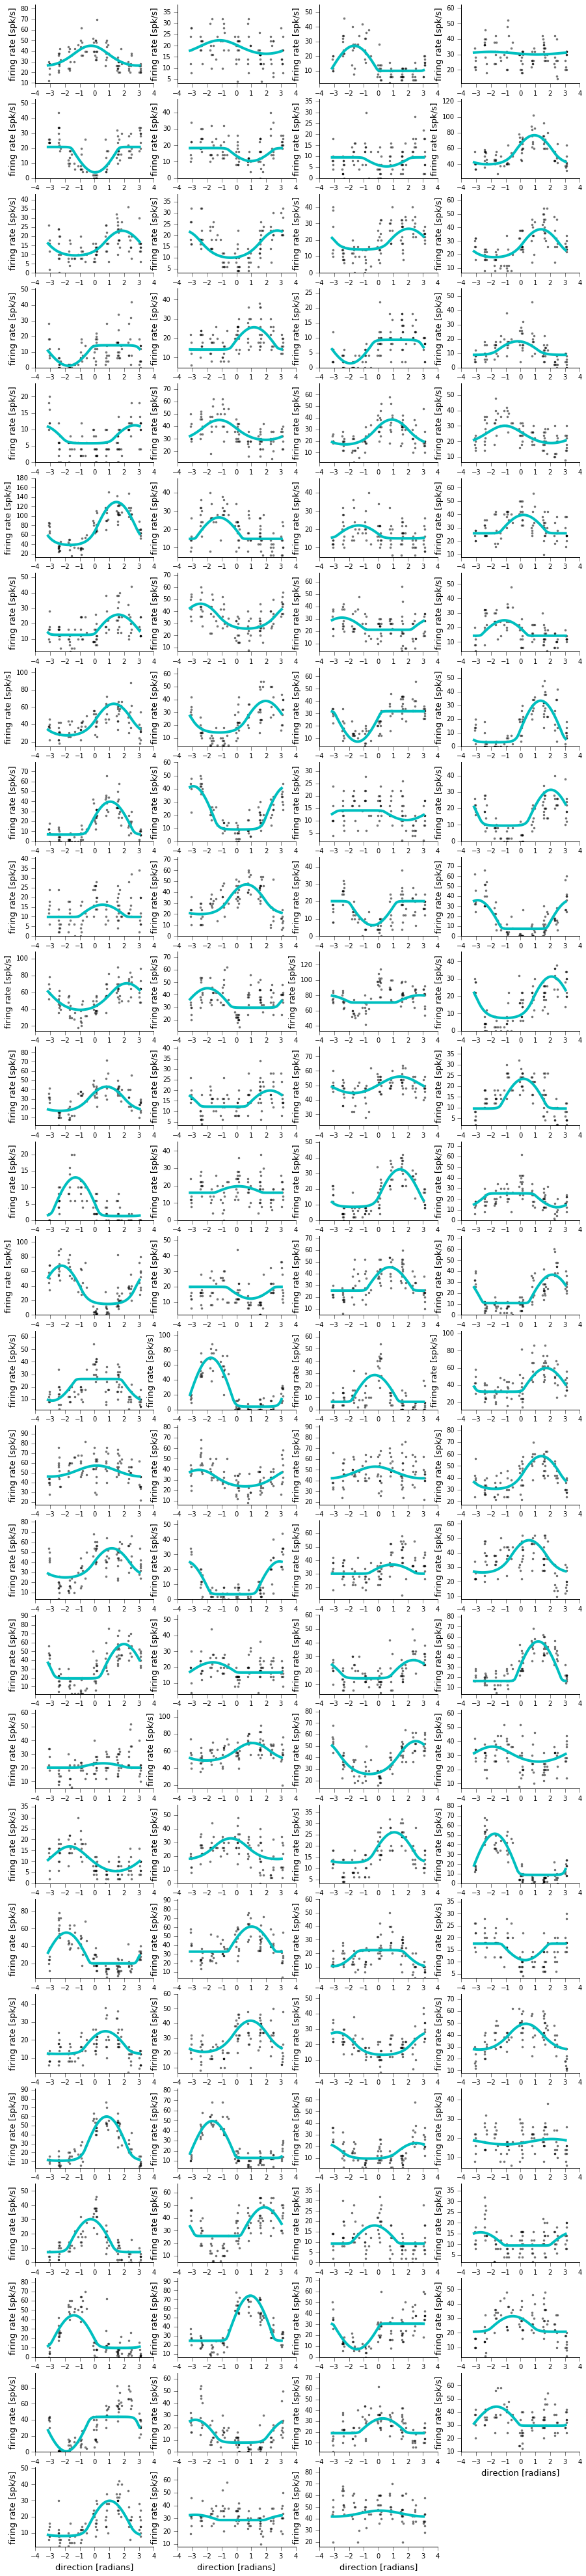

In [30]:
plt.figure(figsize=[15,70])

for neuron in range(len(M1_select)):
    plt.subplot(27,4,neuron+1)
    pop.display(x_test, Y_test[:, M1_select[neuron]], neuron=neuron, 
                ylim=[0.8*np.min(Y_test[:, M1_select[neuron]]), 1.2*np.max(Y_test[:, M1_select[neuron]])])
    #plt.axis('off')

plt.show()

## Decode reach direction from population vector

In [31]:
xhat_test = pop.decode(Y_test[:, M1_select])

### Visualize decoded reach direction

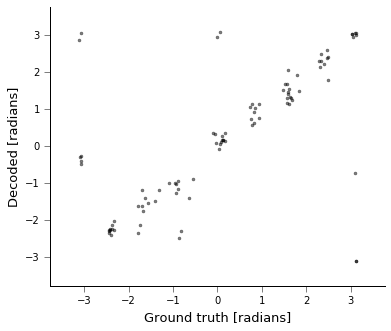

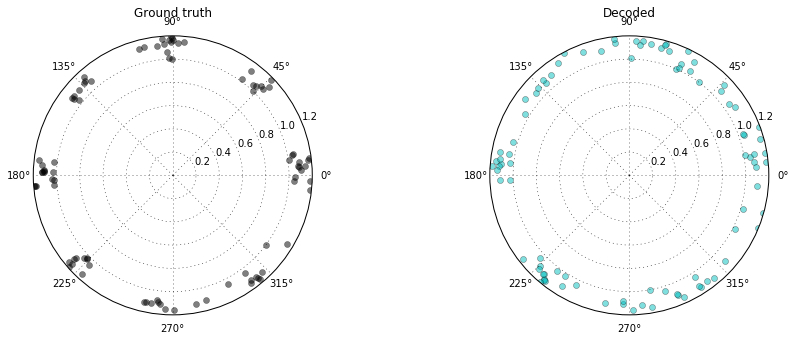

In [32]:
#plt.xkcd()
plt.figure(figsize=[6,5])

plt.plot(x_test, xhat_test, 'k.', alpha=0.5)
plt.xlim([-1.2*np.pi, 1.2*np.pi])
plt.ylim([-1.2*np.pi, 1.2*np.pi])
plt.xlabel('Ground truth [radians]')
plt.ylabel('Decoded [radians]')
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.figure(figsize=[15,5])
jitter = 0.2*np.random.rand(x_test.shape[0])
plt.subplot(121, polar=True)
plt.plot(x_test, np.ones(x_test.shape[0]) + jitter, 'ko', alpha=0.5)
plt.title('Ground truth')

plt.subplot(122, polar=True)
plt.plot(xhat_test, np.ones(xhat_test.shape[0]) + jitter, 'co', alpha=0.5)
plt.title('Decoded')
plt.show()

### Score decoding performance

In [33]:
circ_corr = pop.score(x_test, xhat_test, method='circ_corr')
print 'Circular Correlation: %f' % (circ_corr)
cosine_dist = pop.score(x_test, xhat_test, method='cosine_dist')
print 'Cosine Distance: %f' % (cosine_dist)

Circular Correlation: 0.383749
Cosine Distance: 0.806964
